In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [12]:
sns.set(style="whitegrid", context="talk")
os.makedirs("eda", exist_ok=True)
print("Ready — outputs will be saved to ./eda")

Ready — outputs will be saved to ./eda


In [13]:
path = "/content/drive/MyDrive/kovai.co dataset/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv"
raw = pd.read_csv(path)


In [14]:
raw['Date'] = pd.to_datetime(raw['Date'], dayfirst=True, errors='coerce')

In [15]:
invalid_dates = raw['Date'].isna().sum()
total_rows = len(raw)
with open("eda/initial_data_info.txt","w") as f:
    f.write(f"total_rows: {total_rows}\\ninvalid_date_rows: {invalid_dates}\\n")

print(f"Total rows: {total_rows}, invalid date rows: {invalid_dates}")
raw.head()

Total rows: 1918, invalid date rows: 0


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,2024-08-30,16436,10705,225,19026,3925,59.0
1,2023-09-15,15499,10671,267,18421,4519,61.0
2,2021-12-28,1756,2352,0,3775,0,13.0
3,2023-01-11,10536,8347,223,14072,0,48.0
4,2021-09-11,820,612,0,1283,0,11.0


In [16]:
df = raw.copy()
non_date_cols = [c for c in df.columns if c.lower() != 'date']
for c in non_date_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

In [17]:
df = df.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)
df.set_index('Date', inplace=True)
df.to_csv("eda/cleaned_data.csv")
print("Cleaned data saved -> eda/cleaned_data.csv")
df.head()

Cleaned data saved -> eda/cleaned_data.csv


,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
Date,,,,,,
2019-07-01,15987,9962,407,21223,3715,NaN
2019-07-02,16895,10656,409,21715,3993,NaN
2019-07-03,16613,10658,427,22025,3638,NaN
2019-07-04,16604,10445,437,21868,3576,NaN
2019-07-05,16040,10532,400,20697,2856,NaN


In [18]:
df['Total'] = df.sum(axis=1, numeric_only=True)
desc = df.describe().T
desc.to_csv("eda/describe_table.csv")
print("Saved descriptive stats -> eda/describe_table.csv")
desc

Saved descriptive stats -> eda/describe_table.csv


,count,mean,std,min,25%,50%,75%,max
Local Route,1918.0,9891.395203,6120.715714,1.0,3044.50,11417.0,15517.50,21070.0
Light Rail,1918.0,7195.446298,3345.616428,0.0,4463.50,7507.0,10008.25,15154.0
Peak Service,1918.0,179.581335,156.532738,0.0,0.00,193.0,313.75,1029.0
Rapid Route,1918.0,12597.213243,6720.494557,0.0,6383.00,13106.5,17924.75,28678.0
School,1918.0,2352.694995,2494.766306,0.0,0.00,567.5,4914.00,7255.0
Other,1898.0,43.390411,41.746882,0.0,14.00,40.0,68.00,1105.0
Total,1918.0,32259.269030,18147.879145,4.0,14043.75,34855.5,48301.50,69752.0


In [19]:
yearly = df['Total'].resample('Y').sum().rename('yearly_total')
yearly.to_csv("eda/yearly_total.csv")
yearly_mean = df['Total'].resample('Y').mean().rename('yearly_mean')
yearly_mean.to_csv("eda/yearly_mean.csv")

/tmp/ipython-input-543742202.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = df['Total'].resample('Y').sum().rename('yearly_total')
/tmp/ipython-input-543742202.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_mean = df['Total'].resample('Y').mean().rename('yearly_mean')


Yearly totals and plot saved -> eda/


(Date
 2019-12-31    44471.625000
 2020-12-31    26327.237705
 2021-12-31    25499.750685
 2022-12-31    29679.000000
 2023-12-31    37112.791781
 2024-12-31    37979.183150
 Freq: YE-DEC, Name: yearly_mean, dtype: float64,
 Date
 2019-12-31     8182779.0
 2020-12-31     9635769.0
 2021-12-31     9307409.0
 2022-12-31    10832835.0
 2023-12-31    13546169.0
 2024-12-31    10368317.0
 Freq: YE-DEC, Name: yearly_total, dtype: float64)

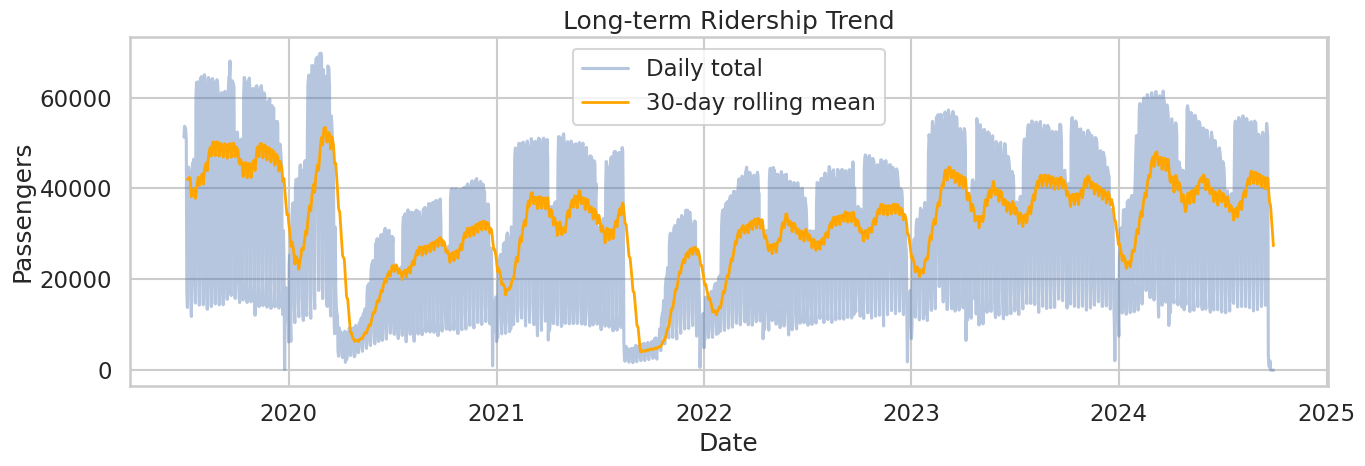

In [45]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df['Total'], label='Daily total', alpha=0.4)
plt.plot(df['Total'].rolling(30, min_periods=7).mean(), label='30-day rolling mean', linewidth=2, color='orange')
plt.title("Long-term Ridership Trend")
plt.xlabel("Date"); plt.ylabel("Passengers")
plt.legend()
plt.tight_layout()
plt.savefig("eda/long_term_trend.png", dpi=150)
#plt.close()
print("Yearly totals and plot saved -> eda/")
yearly_mean, yearly

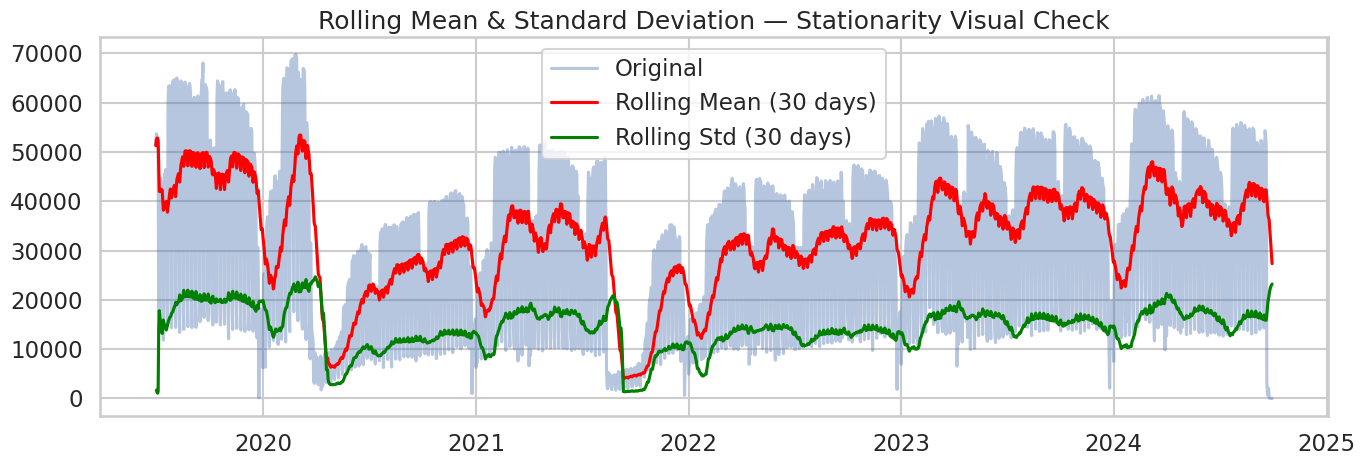

In [23]:
ts = df['Total'].dropna()

roll_mean = ts.rolling(window=30, min_periods=1).mean()
roll_std  = ts.rolling(window=30, min_periods=1).std()

plt.figure(figsize=(14,5))
plt.plot(ts, label='Original', alpha=0.4)
plt.plot(roll_mean, color='red', label='Rolling Mean (30 days)')
plt.plot(roll_std, color='green', label='Rolling Std (30 days)')
plt.title("Rolling Mean & Standard Deviation — Stationarity Visual Check")
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
# KPSS test cell (run after cleaned df is available)
from statsmodels.tsa.stattools import kpss
ts = df['Total'].dropna()
stat, p_value, lags, crit = kpss(ts, regression='c', nlags='auto')
with open("eda/kpss_result.txt","w") as f:
    f.write(f"KPSS statistic: {stat}\\np-value: {p_value}\\nlags: {lags}\\ncrit: {crit}\\n")
# Interpretation helper (for your notes):
if p_value < 0.05:
    print("KPSS: series is likely NON-STATIONARY (reject null of stationarity). Consider differencing or detrending.")
else:
    print("KPSS: series is likely STATIONARY (fail to reject null).")


KPSS: series is likely NON-STATIONARY (reject null of stationarity). Consider differencing or detrending.


/tmp/ipython-input-388676536.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p_value, lags, crit = kpss(ts, regression='c', nlags='auto')


In [31]:
# Cell: Augmented Dickey–Fuller (ADF) Test
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(ts)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

if adf_result[1] < 0.05:
    print("\nADF Result: Stationary (reject H0)")
else:
    print("\nADF Result: Non-stationary (fail to reject H0)")


ADF Statistic: -4.306887195834169
p-value: 0.0004321704100884992
Critical Value (1%): -3.4338036790464495
Critical Value (5%): -2.8630656035129878
Critical Value (10%): -2.5675821738080615

ADF Result: Stationary (reject H0)


In [44]:
# Cell 7: Weekly seasonality (median by day-of-week) and test
df['dow'] = df.index.day_name()
weekly_median = df.groupby('dow')['Total'].median().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
weekly_mean = df.groupby('dow')['Total'].mean().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
weekly_median.to_csv("eda/weekly_median.csv")
weekly_mean.to_csv("eda/weekly_mean.csv")
print(weekly_mean)
print(weekly_median)



dow
Monday       36139.364964
Tuesday      41572.350365
Wednesday    41836.244526
Thursday     41104.802920
Friday       39379.200730
Saturday     14931.828467
Sunday       10851.091241
Name: Total, dtype: float64
dow
Monday       39854.5
Tuesday      43907.0
Wednesday    44150.5
Thursday     43136.5
Friday       41767.5
Saturday     15124.0
Sunday       11204.0
Name: Total, dtype: float64


In [26]:
weekday_vals = df[df.index.dayofweek < 5]['Total'].dropna()
weekend_vals = df[df.index.dayofweek >= 5]['Total'].dropna()
ttest_res = stats.ttest_ind(weekday_vals, weekend_vals, equal_var=False)
with open("eda/weekday_vs_weekend_ttest.txt","w") as f:
    f.write(str(ttest_res))

In [27]:
df['month'] = df.index.month
groups = [group['Total'].values for name, group in df.groupby('month')]
anova_res = stats.f_oneway(*groups)
with open("eda/monthly_anova.txt","w") as f:
    f.write(str(anova_res))
print("Monthly ANOVA result:", anova_res)

Monthly ANOVA result: F_onewayResult(statistic=np.float64(12.914483941311122), pvalue=np.float64(5.6678155513784114e-24))


Text(0.5, 1.0, 'Seasonality heatmap (year vs month)')

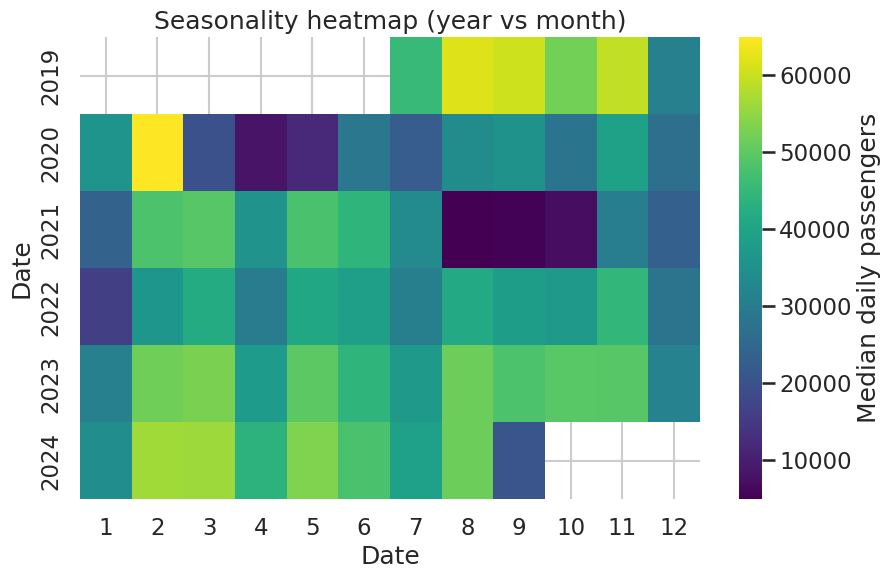

In [43]:
pivot = df.pivot_table(values='Total', index=df.index.year, columns=df.index.month, aggfunc='median')
plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap='viridis', cbar_kws={'label':'Median daily passengers'})
plt.title("Seasonality heatmap (year vs month)")
#plt.savefig("eda/seasonality_heatmap.png", dpi=150)
#plt.close()

In [33]:
baseline = df['Total'].rolling(window=30, min_periods=7).median()
dev = df['Total'] - baseline
neg_dev_30 = (dev.where(dev < 0, 0)).rolling(window=30, min_periods=10).sum()
drop_idx = neg_dev_30.idxmin()
mask = df['Total'] < 0.85 * baseline

In [34]:
try:
    drop_start = mask[:drop_idx][mask[:drop_idx]].index.min()
    drop_end = mask[drop_idx:][mask[drop_idx:]].index.max()
except:
    drop_start, drop_end = None, None
if drop_start is not None:
    before_window = df['Total'][:drop_start].rolling(30, min_periods=7).median().dropna()
    baseline_before = before_window.iloc[-1] if not before_window.empty else np.nan
    during_mean = df['Total'][drop_start:drop_end].mean() if drop_end is not None else np.nan
    pct_drop = (baseline_before - during_mean) / baseline_before * 100 if baseline_before and not np.isnan(during_mean) else np.nan
else:
    pct_drop = np.nan

with open("eda/detected_drop_info.txt","w") as f:
    f.write(f"drop_start:{drop_start}\\ndrop_end:{drop_end}\\nbaseline_before:{baseline_before}\\nduring_mean:{during_mean}\\npct_drop:{pct_drop}\\n")

print(f"Detected drop: start={drop_start}, end={drop_end}, pct_drop={pct_drop:.1f}%")

Detected drop: start=2019-07-07 00:00:00, end=2024-09-29 00:00:00, pct_drop=37.2%


In [36]:
service_cols = [c for c in df.columns if c not in ['Total','dow','month']]
stability = []
for s in service_cols:
    mean = df[s].mean()
    std = df[s].std()
    cv = std / mean if mean != 0 else np.nan
    total_sum = df[s].sum()
    stability.append({'service': s, 'mean': mean, 'std': std, 'cv': cv, 'total_sum': total_sum})
stab_df = pd.DataFrame(stability).sort_values('cv')
#stab_df.to_csv("eda_proof/service_stability_rank.csv", index=False)
#print("Stability ranking saved -> eda_proof/service_stability_rank.csv")
stab_df


,service,mean,std,cv,total_sum
1,Light Rail,7195.446298,3345.616428,0.464963,13800866.0
3,Rapid Route,12597.213243,6720.494557,0.533491,24161455.0
0,Local Route,9891.395203,6120.715714,0.618792,18971696.0
2,Peak Service,179.581335,156.532738,0.871654,344437.0
5,Other,43.390411,41.746882,0.962122,82355.0
4,School,2352.694995,2494.766306,1.060387,4512469.0


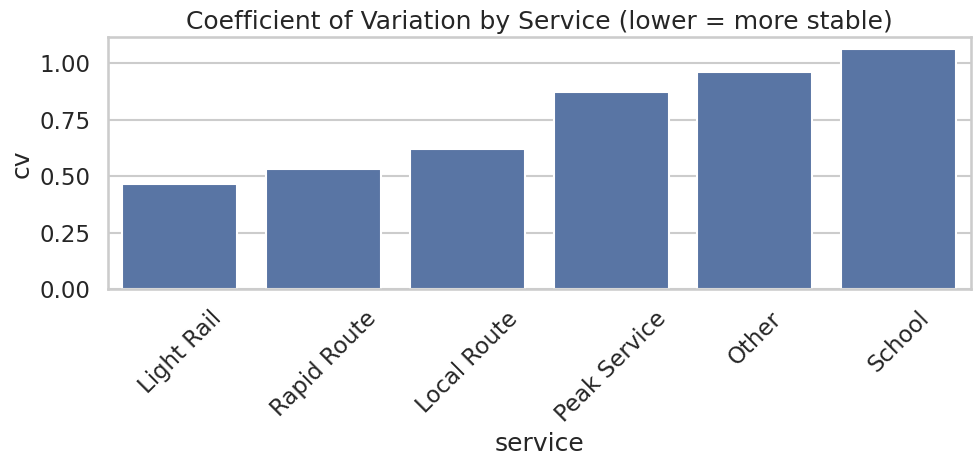

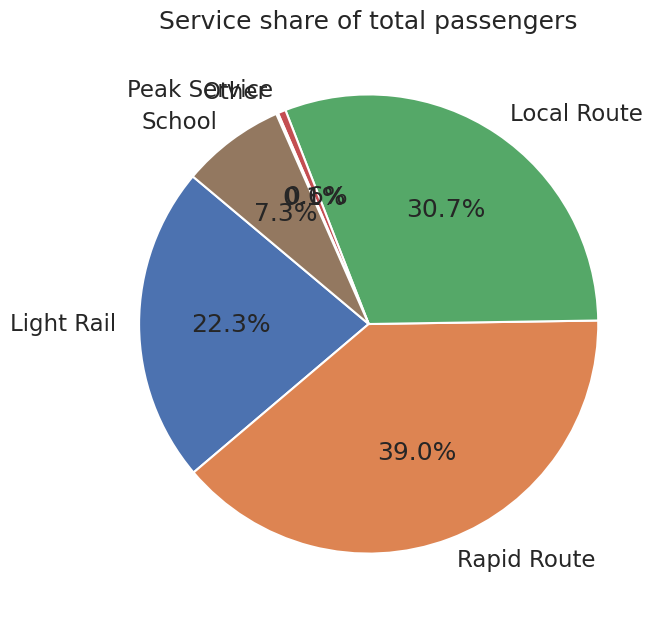

In [39]:
plt.figure(figsize=(10,5))
sns.barplot(data=stab_df, x='service', y='cv', order=stab_df['service'])
plt.title("Coefficient of Variation by Service (lower = more stable)")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig("eda/service_cv_bar.png", dpi=150)
#plt.close()

plt.figure(figsize=(7,7))
plt.pie(stab_df['total_sum'], labels=stab_df['service'], autopct='%1.1f%%', startangle=140)
plt.title("Service share of total passengers")
plt.tight_layout()
#plt.savefig("eda_proof/service_share_pie.png", dpi=150)
#plt.close()


In [40]:
res = {}
for s in ['Peak Service','School']:
    if s in df.columns:
        res[s] = {
            'mean': df[s].mean(),
            'median': df[s].median(),
            'std': df[s].std(),
            'weekday_mean': df[df.index.dayofweek < 5][s].mean(),
            'weekend_mean': df[df.index.dayofweek >=5][s].mean(),
            'weekday_to_weekend_ratio': (df[df.index.dayofweek < 5][s].mean() / df[df.index.dayofweek >=5][s].mean()) if df[df.index.dayofweek >=5][s].mean() != 0 else np.nan
        }

import json
#with open("eda_proof/peak_school_numeric.json","w") as f:
#    json.dump(res, f, indent=2)
#print("Saved Peak vs School numeric summary -> eda_proof/peak_school_numeric.json")
res


{'Peak Service': {'mean': np.float64(179.5813347236705),
  'median': 193.0,
  'std': 156.5327380328073,
  'weekday_mean': np.float64(251.41386861313867),
  'weekend_mean': np.float64(0.0),
  'weekday_to_weekend_ratio': nan},
 'School': {'mean': np.float64(2352.694994786236),
  'median': 567.5,
  'std': 2494.7663064135054,
  'weekday_mean': np.float64(3293.729197080292),
  'weekend_mean': np.float64(0.10948905109489052),
  'weekday_to_weekend_ratio': np.float64(30082.726666666666)}}

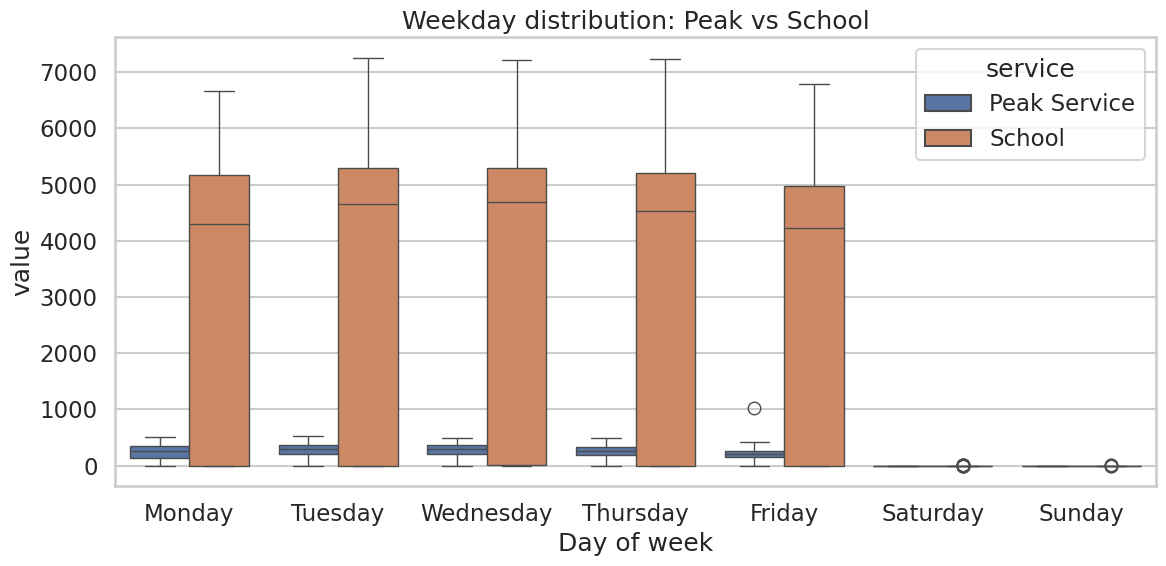

In [41]:
# Boxplot by weekday for Peak and School
plt.figure(figsize=(12,6))
plot_cols = [c for c in ['Peak Service','School'] if c in df.columns]
melt = df[plot_cols + ['dow']].melt(id_vars='dow', var_name='service', value_name='value')
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.boxplot(data=melt, x='dow', y='value', hue='service', order=order)
plt.title("Weekday distribution: Peak vs School")
plt.xlabel("Day of week")
plt.tight_layout()
#plt.savefig("eda_proof/peak_school_weekday_boxplot.png", dpi=150)
#plt.close()


In [47]:
stl = STL(df['Total'].dropna(), period=7, robust=True)
res = stl.fit()
comp = pd.DataFrame({'trend':res.trend, 'seasonal':res.seasonal, 'resid':res.resid})
comp.to_csv("eda/stl_components.csv")
var_total = np.nanvar(df['Total'].dropna())
var_season = np.nanvar(res.seasonal)
var_trend = np.nanvar(res.trend)
with open("eda/stl_variance_explained.txt","w") as f:
    f.write(f"var_total:{var_total}\\nvar_season:{var_season}\\nvar_trend:{var_trend}\\nseason_pct:{var_season/var_total*100:.2f}\\ntrend_pct:{var_trend/var_total*100:.2f}\\n")
print("STL components and variance explained saved/")


STL components and variance explained saved/
